# Energy generation and capacity forecast

In [13]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from statsmodels.tsa.stattools import adfuller


from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential


plt.rcParams["figure.figsize"] = (16,10)
sns.set_style("whitegrid")

In [28]:
energy_data = pd.read_csv("data/daily_enery_data.csv", index_col='date', parse_dates=True)
energy_data

,generacion_GWh,capacidad_efectiva_neta_mv,str_date
date,,,
2000-01-01,87.924,11806.970,2000 enero 01
2000-01-02,88.754,11806.970,2000 enero 02
2000-01-03,105.884,11806.970,2000 enero 03
2000-01-04,109.207,11806.970,2000 enero 04
2000-01-05,109.069,11806.970,2000 enero 05
...,...,...,...
2020-09-15,203.681,19866.117,2020 septiembre 15
2020-09-16,196.657,19326.117,2020 septiembre 16
2020-09-17,202.818,19326.117,2020 septiembre 17


# Data Exploration

In [29]:
energy_data[['generacion_GWh', 'capacidad_efectiva_neta_mv']].describe()

,generacion_GWh,capacidad_efectiva_neta_mv
count,7564.000000,7564.000000
mean,155.923453,14532.188154
std,26.615936,1660.981658
min,86.532000,11802.970000
25%,134.665250,13335.840000
50%,156.150500,13519.200000
75%,178.504000,16229.848000
max,216.153000,19866.117000


In [30]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7564 entries, 2000-01-01 to 2020-09-19
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   generacion_GWh              7564 non-null   float64
 1   capacidad_efectiva_neta_mv  7564 non-null   float64
 2   str_date                    7564 non-null   object 
dtypes: float64(2), object(1)
memory usage: 236.4+ KB


Text(0.5, 1.0, 'Energy Generation (Daily) - Ghw')

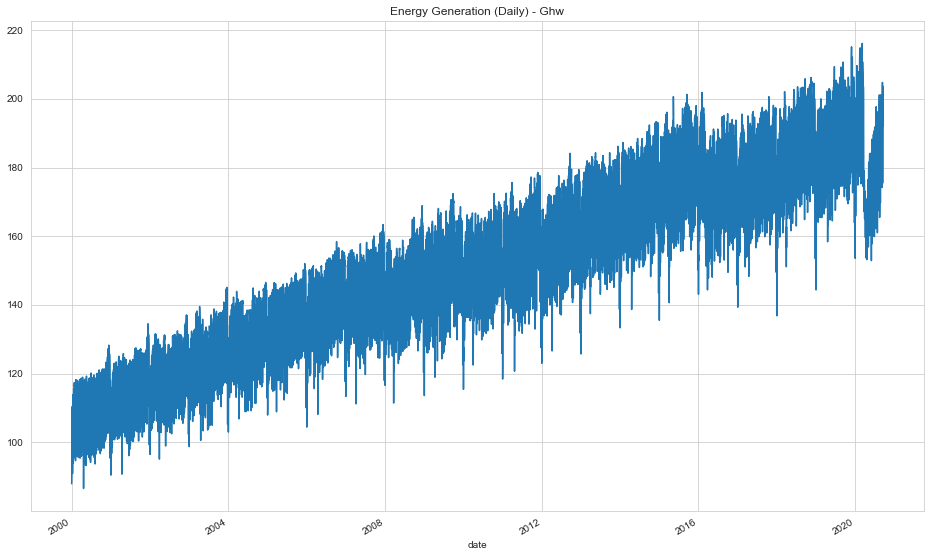

In [31]:
energy_data['generacion_GWh'].plot()
plt.title("Energy Generation (Daily) - Ghw")

# Normality tests

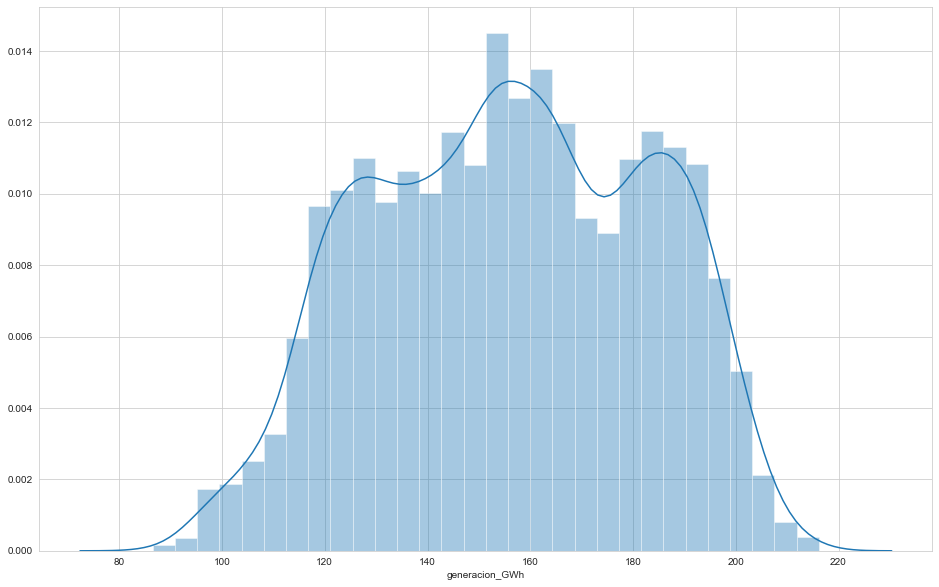

In [32]:
sns.distplot(energy_data['generacion_GWh'])

In [33]:
stat, p = stats.normaltest(energy_data['generacion_GWh'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1063.999, p=0.000
Data does not look Gaussian (reject H0)


In [34]:
stats.kurtosis(energy_data['generacion_GWh'])

-0.90424902849412

In [35]:
stats.skew(energy_data['generacion_GWh'])

-0.08353614924334736

# Augmented Dickey Fuller test

In [36]:
adfuller(energy_data['generacion_GWh'], autolag='AIC')

(-1.9214796728010077,
 0.3220248347306134,
 36,
 7527,
 {'1%': -3.4312190755290266,
  '5%': -2.86192406579182,
  '10%': -2.5669744337969775},
 47967.07720572307)

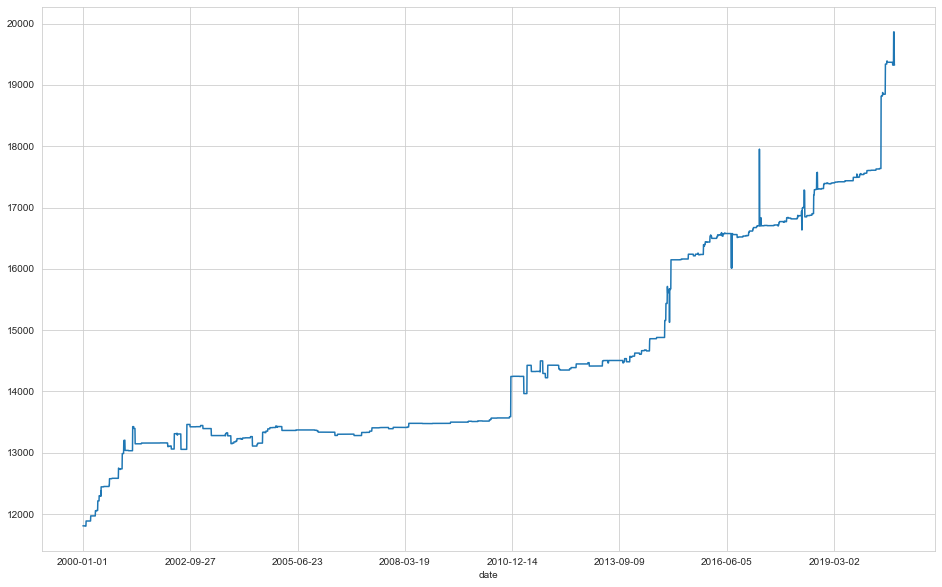

In [21]:
energy_data['capacidad_efectiva_neta_mv'].plot()

# Data Split

In [41]:
threshold_date = energy_data.iloc[round(energy_data.shape[0] * 0.8)]
threshold_date.name

Timestamp('2016-07-26 00:00:00')

In [45]:
train_data = energy_data[energy_data.index  <= threshold_date.name]
test_data = energy_data[energy_data.index  <= threshold_date.name]

# LSTM Neural Network

Source https://wiki.pathmind.com/lstm

In [9]:
# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [53]:
class DeepLearningUTSModel:
    
    
    def __init__(self, data, epochs=10):
        
        self.data = data
        self.epochs = epochs
    
    @classmethod
    def create_ts_sequences(cls, series, lag):
        """Create vectors along a time series with
        an specified number of lags"""
        
        X, y = [], []
        
        for t in range(len(series)):
            
            # Index + defined_lag t = [t-1, t-2, ..., t-lag]
            t_plus_lag = t + lag
            
            if t_plus_lag > len(series)-1:
                break
            
            X_seq, y_seq = series[t:t_plus_lag], series[t_plus_lag]
            
            # Append arrays to the 
            X.append(X_seq)
            y.append(y_seq)
            
        return np.array(X), np.array(y)
        
    def vanillaLSTM(self, lags, n_features=1):
        """Minimalist LSTM model
            
           n_features=1 for univariate time series
        """
        
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(lags, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        
        model.fit(X_train, y_train, epochs=self.epochs, verbose=0)
        
        self.model = model

        return model
        
    
        

In [55]:
X_train, y_train = DeepLearningUTSModel.create_ts_sequences(series=train_data['generacion_GWh'], lag=2)
X_test, y_test = DeepLearningUTSModel.create_ts_sequences(series=test_data['generacion_GWh'], lag=2)